In [7]:
import logging
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from urllib.parse import urlparse
import mlflow 
import mlflow.sklearn 

import joblib
import pickle

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
#Get datetime features
class DateExtractor(BaseEstimator,TransformerMixin):
    def __init__(self):
        print('Pre processor initiated')
    
    def fit(self,X,y):
        return self
    
    def transform(self,x):
        dataset = x.copy()
        
        dataset['month'] = dataset.index.month
        dataset['year'] = dataset.index.year
        dataset['day'] = dataset.index.day
        dataset['weekofYear'] = dataset.index.weekofyear
        dataset.reset_index(inplace=True)
        dataset.drop(['Date','Sales','Customers'], axis=1, inplace=True)
        
        dataset = pd.get_dummies(dataset)
        return dataset

In [10]:
#rmse shows the error of the model in predicting quantitative data
def rmse(x, y):
    return sqrt(mean_squared_error(x, y))


#mape measures how acurate a forecast is 
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  
  

In [11]:
try:
    train = pd.read_csv(r"..\data\train.csv",parse_dates = True, low_memory = False,index_col = 'Date')
    store = pd.read_csv(r'..\data\store.csv',low_memory = False)
    test = pd.read_csv(r'..\data\test.csv',low_memory = False,index_col = 'Date')
except Exception as e:
    logger.exception("Unable to load csv file", e)

mlflow.set_experiment('pred_pharm_sales')
with mlflow.start_run():
    X = train.copy()
    y= train.Sales
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    n_estimators = 30
    
    model_pipeline = Pipeline(
            steps = [
                ('datetime_features', DateExtractor()),
                ('rdf',RandomForestRegressor(n_estimators=n_estimators))
            ]
    )
    
    mlflow.log_param("est_num",n_estimators)
    model_pipeline.fit(X_train,y_train)
    
    #file name with datetime stamp 
    #filename = datetime.datetime.now()
    #cur_date_time_str = str(cur_date_time)
    #extension = ".pkl"
    #filename = cur_date_time_str + extension
    
    #joblib.dump(model_pipeline.named_steps["rdf"],filename)
    #pickle.dump(model_pipeline.named_steps["rdf"],open(filename,'wb'))
    y_pred = model_pipeline.predict(X_test)
    print("Regresion Model Score" , ":" , model_pipeline.score(X_train, y_train) , "," ,
          "Out of Sample Test Score" ,":" , model_pipeline.score(X_test, y_test))
            
        
    mlflow.log_metric("r", model_pipeline.score(X_test, y_test))
    mlflow.log_metric("rmse", rmse(y_test, y_pred))
    mlflow.log_metric("mape", mape(y_test, y_pred))
        
    mlflow.sklearn.log_model(model_pipeline, "model")


Pre processor initiated
Regresion Model Score : 0.9763518630768218 , Out of Sample Test Score : 0.8432984625630713


Pre processor initiated


Text(0.5, 0, 'Relative Importance')

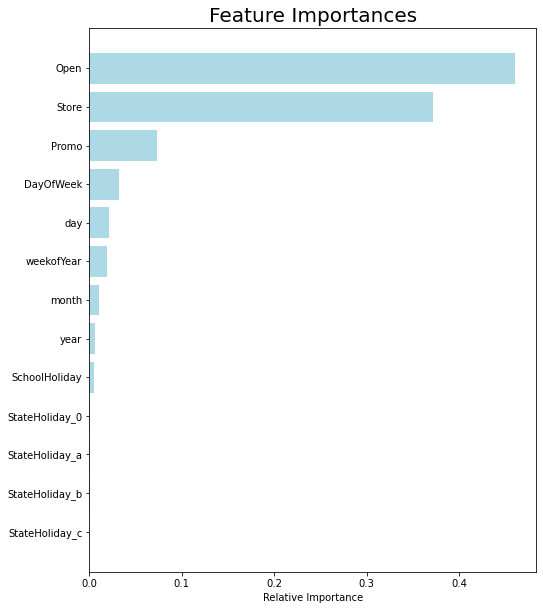

In [12]:
x = DateExtractor()
x = x.transform(X_train)
features = x.columns
importances = model_pipeline.named_steps["rdf"].feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')